In [18]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import GRU, Dense, Dropout

In [5]:

# Step 1: Data cleaning
data = yf.download(tickers='ETH-usd', period='max', interval='1d')
data.dropna(inplace=True)
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984
...,...,...,...,...,...,...
2023-01-19,1515.249634,1557.970337,1514.380005,1552.556519,1552.556519,6432638856
2023-01-20,1552.373657,1659.885742,1544.917847,1659.754150,1659.754150,8528894754
2023-01-21,1659.706055,1674.179321,1626.812988,1627.118164,1627.118164,8859250310


In [6]:

data.drop([ 'Close'], axis=1, inplace=True)
data

,Open,High,Low,Adj Close,Volume
Date,,,,,
2017-11-09,308.644989,329.451996,307.056000,320.884003,893249984
2017-11-10,320.670990,324.717987,294.541992,299.252991,885985984
2017-11-11,298.585999,319.453003,298.191986,314.681000,842300992
2017-11-12,314.690002,319.153015,298.513000,307.907990,1613479936
2017-11-13,307.024994,328.415009,307.024994,316.716003,1041889984
...,...,...,...,...,...
2023-01-19,1515.249634,1557.970337,1514.380005,1552.556519,6432638856
2023-01-20,1552.373657,1659.885742,1544.917847,1659.754150,8528894754
2023-01-21,1659.706055,1674.179321,1626.812988,1627.118164,8859250310


In [7]:
# Step 3: Data normalization (cont.)
scaler = MinMaxScaler()
data_close = data[['Adj Close']]
data_close = scaler.fit_transform(data_close)
data_close

array([[0.0500395 ],
       [0.0454642 ],
       [0.04872747],
       ...,
       [0.32632867],
       [0.32659601],
       [0.32496688]])

In [8]:
# Step 4: Splitting the data
X = data[['Open', 'High', 'Low', 'Volume']]
X = scaler.fit_transform(X)
y = data_close
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [9]:
# Step 5: Reshaping the data
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
print("x", X.shape)
print('y',y.shape)
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('Y_test', y_test.shape) 
print('X_train.shape[1]', X_train.shape[1])
print('X_train.shape[2]', X_train.shape[2])

x (1902, 4)
y (1902, 1)
X_train (1521, 1, 4)
y_train (1521, 1)
X_test (381, 1, 4)
Y_test (381, 1)
X_train.shape[1] 1
X_train.shape[2] 4


In [10]:
# Step 6: Building the GRU model (cont.)

model = Sequential()
model.add(GRU(100, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True , activation= 'softmax'))
model.add(Dropout(0.2))
model.add(GRU(100, activation= 'softmax'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1, 100)            31800     
                                                                 
 dropout (Dropout)           (None, 1, 100)            0         
                                                                 
 gru_1 (GRU)                 (None, 100)               60600     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 92,501
Trainable params: 92,501
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Step 7: Training and evaluating the model
history = model.fit(X_train, y_train, epochs=250, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/250
48/48 [==============================] - 8s 25ms/step - loss: 0.0871 - val_loss: 0.1307
Epoch 2/250
48/48 [==============================] - 0s 9ms/step - loss: 0.0714 - val_loss: 0.0976
Epoch 3/250
48/48 [==============================] - 0s 10ms/step - loss: 0.0651 - val_loss: 0.0798
Epoch 4/250
48/48 [==============================] - 0s 10ms/step - loss: 0.0634 - val_loss: 0.0719
Epoch 5/250
48/48 [==============================] - 0s 10ms/step - loss: 0.0629 - val_loss: 0.0685
Epoch 6/250
48/48 [==============================] - 0s 10ms/step - loss: 0.0627 - val_loss: 0.0666
Epoch 7/250
48/48 [==============================] - 0s 10ms/step - loss: 0.0619 - val_loss: 0.0653
Epoch 8/250
48/48 [==============================] - 1s 11ms/step - loss: 0.0611 - val_loss: 0.0632
Epoch 9/250
48/48 [==============================] - 0s 10ms/step - loss: 0.0595 - val_loss: 0.0607
Epoch 10/250
48/48 [==============================] - 0s 10ms/step - loss: 0.0570 - val_loss: 0.0575


In [12]:
# Evaluate the model on the test set
score = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {score:.4f}')

Test loss: 0.0002


In [14]:

# Step 8: Tuning the Hyperparameters
# You can use techniques such as grid search or random search to find the best values for the model's hyperparameters

# Step 9: Testing the model
y_pred = model.predict(X_test)
print('y_pred',y_pred.shape)
print('y_test',y_test.shape)
#y_pred = y_pred.reshape(-1,1)
#y_pred = np.nan_to_num(y_pred)
#y_pred = scaler.inverse_transform(y_pred)
#y_pred = scaler.inverse_transform(y_pred[:,[-1]])
#y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
#y_test = np.nan_to_num(y_test)


#evaluat
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = 100 * np.mean(np.abs((y_test - y_pred) / y_test))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAPE: {:.4f}%".format(mape))
print("RMSE: {:.4f}".format(rmse))
print("MSE: {:.4f}".format(mse))
print("MAE:{:.4f}".format(mae))

12/12 [==============================] - 0s 4ms/step
y_pred (381, 1)
y_test (381, 1)
MAPE: 3.5144%
RMSE: 0.0150
MSE: 0.0002
MAE:0.0121


In [15]:
def smape(y_true, y_pred):
    return 200 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

SMAPE1 = smape(y_test, y_pred)
print("smape: {:.4f}%".format(SMAPE1))

smape: 3.4366%


ValueError: x and y must have same first dimension, but have shapes (3051,) and (611, 1)

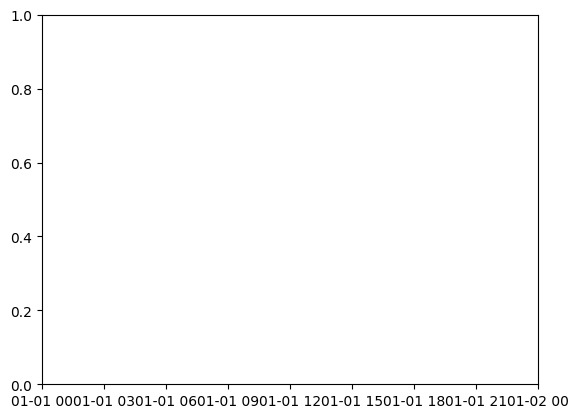

In [16]:
import matplotlib.pyplot as plt

# Assume that you have stored the date information in a variable called 'date'
# Assume that you have stored the predictions in a variable called 'y_pred'
# Assume that you have stored the test data in a variable called 'y_test'

# Plot the test data and predictions on a line chart
plt.plot(data.index, y_pred, label='Predictions')
plt.plot(data.index, y_test, label='Test Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [16]:
y_pred = scaler.inverse_transform(y_pred)
#y_pred = scaler.inverse_transform(y_pred[:,[-1]])
#y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
print ('y_pred',y_pred)

ValueError: non-broadcastable output operand with shape (381,1) doesn't match the broadcast shape (381,4)

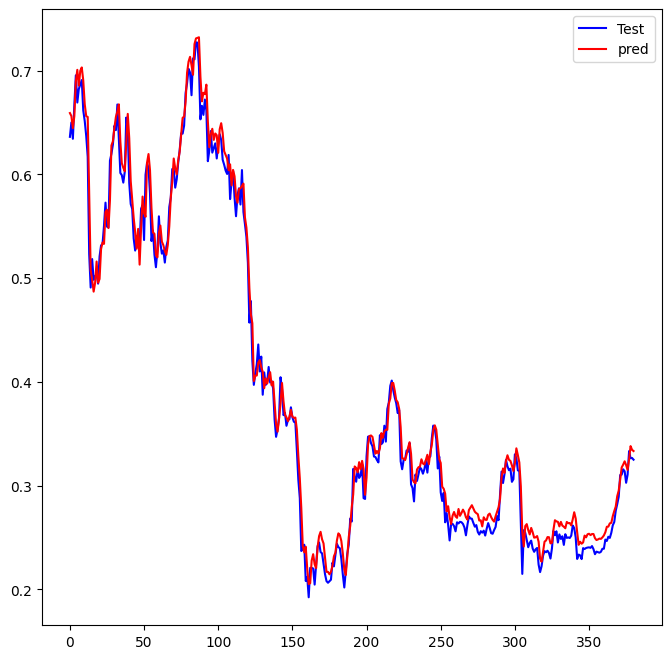

In [19]:
plt.figure(figsize=(8,8))
plt.plot(y_test, color = 'blue', label = 'Test')
plt.plot(y_pred, color = 'red', label = 'pred')
plt.legend()
plt.show()